In [1]:
import os
import textract
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
en_stop = set(nltk.corpus.stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

In [2]:
resume_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Selected/'
reference = '/Users/Ketki/Documents/MS Theses/Candidate list.xlsx'
jd_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/'
fig_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Fig/'

In [3]:
def preprocessText(text, textEncoding = 'windows-1252'):
    text = re.sub(r'[^\x20-\x7e]',r' ', text.decode(encoding = textEncoding))
    return text

In [4]:
def getResumeReference(referencePath):
    refDataFrame = pd.read_excel(reference)
    return refDataFrame

In [5]:
def getResumeDataFrame(resumePath):
    resume_list = []
    r_file_list = []
    
    for file in os.listdir(resume_path):
        if file == '.DS_Store':
            continue
            
        filename = resume_path + file
        #print(filename)
        r_file_list.append(file)
        
        try:
            text = textract.process(filename)
            text = preprocessText(text, 'utf-8')
            resume_list.append(text)
        except Exception as se:
            print('{} -> {}'.format(file, se))
            
    resumeDataFrame = pd.DataFrame(list(zip(r_file_list,resume_list)), \
                             columns = ['res_name','res_contents'])
    refDataFrame = getResumeReference(reference)
    
    resumeDataFrame = resumeDataFrame.join(refDataFrame.set_index('res_name'),\
                                           on = 'res_name')
    
    return resumeDataFrame

In [6]:
def getJobNationality(jobFile):
    reNation = re.search('jd_([a-z]*)[0-9]*.*', jobFile, re.IGNORECASE)
    if reNation:
        nationality = reNation.group(1)
    else:
        raise 'Unknown JD Nationality'
        
    return nationality

In [7]:
def getJobDescription(jobFile, JDname):
    jobTitle = 'input'
    jobName = 'JDname'
    nationality = getJobNationality(jobFile)
    jobText = textract.process(jobFile)
    jobText = preprocessText(jobText, 'utf-8')
    return {'res_name': jobTitle, 
            'res_contents': jobText, 
            'name': jobName, 
            'nationality':  nationality}

In [8]:
def TFIDF(processDataFrame, ratioDf):

    tfidf = TfidfVectorizer(stop_words = 'english', lowercase = True)
    tfidfMatrix = tfidf.fit_transform(processDataFrame['res_contents'])

    # Normalize the tf-idf vectors
    tfidfMatrix = normalize(tfidfMatrix)
    
    # get tfidf value for each word in a dataframe
    feature = tfidf.get_feature_names()
#    index_value = {i[1]:i[0] for i in tfidf.vocabulary_.items()}
    matrixDf = pd.DataFrame(tfidfMatrix.toarray(), columns = feature)
    
    # multiply with computed p ratio
    for i in range(len(ratioDf)):
        try:
            temp = ratioDf['words'].iloc[i]
            matrixDf[temp] = matrixDf[temp]*ratioDf['pRatio'].iloc[i]
        except (KeyError):
            pass
    
    cosine_sim = linear_kernel(matrixDf, matrixDf)
    indices = pd.Series(processDataFrame.index, \
                        index=processDataFrame['res_name']).drop_duplicates()

    idx = indices['input']

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    resume_indices = [i[0] for i in sim_scores]
    selectedResumes = processDataFrame.iloc[resume_indices]
    
    return (matrixDf, selectedResumes, sim_scores)

In [9]:
def getTSNE(matrixDf):
    k = 30
    svd_matrix = TruncatedSVD(n_components = k, \
                              random_state = 0).fit_transform(matrixDf)


    t_sne = TSNE(perplexity = 12, \
                 verbose = 0, \
                 learning_rate = 200).fit_transform(svd_matrix)
    return t_sne

In [10]:
def plot(processDataFrame, t_sne, JDname,fig_path):
    fig = plt.figure(figsize = (10,10))
    plotData = {}
    for i in range(0, t_sne.shape[0]):
        if processDataFrame['res_name'][i] == 'input':

            pass
        elif processDataFrame['nationality'][i] == 'India':
            if 'India' in plotData:
                plotData['India']['X'].append(t_sne[i,0])
                plotData['India']['Y'].append(t_sne[i,1])
            else:
                plotData['India'] = {}
                plotData['India']['X'] = list([t_sne[i,0]])
                plotData['India']['Y'] = list([t_sne[i,1]])
        elif processDataFrame['nationality'][i] == 'Malaysia':
            if 'Malaysia' in plotData:
                plotData['Malaysia']['X'].append(t_sne[i,0])
                plotData['Malaysia']['Y'].append(t_sne[i,1])
            else:
                plotData['Malaysia'] = {}
                plotData['Malaysia']['X'] = list([t_sne[i,0]])
                plotData['Malaysia']['Y'] = list([t_sne[i,1]])
        elif processDataFrame['nationality'][i] == 'China':    
            if 'China' in plotData:
                plotData['China']['X'].append(t_sne[i,0])
                plotData['China']['Y'].append(t_sne[i,1])
            else:
                plotData['China'] = {}
                plotData['China']['X'] = list([t_sne[i,0]])
                plotData['China']['Y'] = list([t_sne[i,1]])
    
    
    for key in plotData.keys():
        if key == 'India':
            slabel = 'resume : India'
            sc = 'r'
            sm = '+'
        elif key == 'China':
            slabel = 'resume : China'
            sc = 'b'
            sm = '*'
        elif key == 'Malaysia':
            slabel = 'resume : Malaysia'
            sc = 'g'
            sm = 'o'
            
        scatter = plt.scatter(plotData[key]['X'], plotData[key]['Y'], \
                              c = sc, marker = sm, \
                              label = slabel)

    plt.legend()    
    plt.grid()
    plt.show()  
    figName = fig_path + JDname + '_new.png'
    plt.savefig(figName)


In [11]:
def getNationalityDf(resumeDataFrame,countryName):
    nDataFrame = resumeDataFrame.loc[lambda resumeDataFrame: resumeDataFrame['nationality'] == countryName]
    nDataFrame = nDataFrame[['res_contents']]
    nDataFrame = nDataFrame.reset_index(drop=True)
    return nDataFrame

In [12]:
def unique_words(text):
    tokens_dict = {}
    text = str(text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if len(token) > 3]
    for word in tokens:
        if word in tokens_dict:
            continue
        else:
            tokens_dict[word] = 1
    return tokens_dict

In [13]:
def getDocFreq(tokens_dict, length):
    tokenDataFrame = pd.DataFrame.from_dict(tokens_dict, orient = 'index')
    valuePDataFrame = tokenDataFrame.div(length)
    return valuePDataFrame

In [14]:
def getRatioPercent(concatDf):
    concatDf = concatDf.fillna(0)
    ratioP = (concatDf.min(axis=1)/concatDf.max(axis=1))
    ratioDf = pd.DataFrame(ratioP)
    ratioDf = ratioDf.reset_index()
    ratioDf = ratioDf.rename(columns={'index':'words',0:'pRatio'})
    return ratioDf

In [15]:
distributionMatrix = {}
def processData(resume_path,jobFile, JDname):
    dictionary = None
    country = ['China','India','Malaysia']
    concatDf = pd.DataFrame()
    resumeDataFrame = getResumeDataFrame(resume_path)
    jobDescription = getJobDescription(jobFile, JDname)
    processDataFrame = resumeDataFrame.append(jobDescription, \
                                              ignore_index = True)
    processDataFrame = processDataFrame.dropna()
    
    for c in country:
        nDataFrame = getNationalityDf(resumeDataFrame, c)
        length = len(nDataFrame)
        for i in range(len(nDataFrame)):
    #    print(nDataFrame['res_contents'][0])
            dic = unique_words(nDataFrame['res_contents'][i])
            if dictionary == None:
                dictionary = dic
            else:
                for k in dic.keys():
                    if k in dictionary:
                        dictionary[k] += 1
                    else:
                        dictionary[k] = 1
    #    tokensDict = getTokensDict(nDataFrame)
        valuePDataFrame = getDocFreq(dictionary, length)
        concatDf = concatDf.merge(valuePDataFrame, left_index = True, right_index = True, how= 'outer')
        concatDf = concatDf.rename(columns={0:c})
    
    ratioDf = getRatioPercent(concatDf)
    matrixDf, selectedResumes, sim_scores = TFIDF(processDataFrame,ratioDf)
    print(selectedResumes)
    print(sim_scores)
    distribution = Counter(selectedResumes['nationality'])
    #print(distribution)

    jobNationality = jobDescription['nationality']
    if jobNationality in distributionMatrix:
        distributionMatrix[jobNationality]['total'] += 1
        
    else:
        distributionMatrix[jobNationality] = defaultdict(int)
        distributionMatrix[jobNationality]['total'] += 1
    
    for key in distribution.keys():
        distributionMatrix[jobNationality][key] += distribution[key]
    tsne = getTSNE(matrixDf)
    plot(processDataFrame, tsne, JDname,fig_path)

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_malaysia.docx
                                      res_name  \
90               Equiom_Isaac Yim_Cosec AM.pdf   
124                     RDM_Trevor Yang_FM.pdf   
91       Mohn_Nisha Babusathiam_Cosec Lead.doc   
83               Rodyk_Nelson Lee_Sr Cosec.pdf   
131            HP_Adrian Hew_Acc Team Lead.pdf   
7     iProperty_Chan Lai Lin_Sr Accountant.pdf   
101     Xander_Ashish Shah_Finance Manager.doc   
121           JTB_Chung Yon Jie_Accountant.pdf   
107  Maybank_Anshul Sthapak_Legal Counsel.docx   
67     Quality Mgmt_Nur Hawa_Admin Officer.pdf   

                                          res_contents  \
90   Name: Yim Lok Kwan, Isaac (ACIS, ACS) Mobile: ...   
124  Trevor Siran YANG, CFA, CPA Tel: +852 67419184...   
91    |Nisha Solai Babusathiam                     ...   
83   CURRICULUM VITAE PERSONAL DETAIL Name Gender N...   
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber...   
7    CHAN LAI LIN 33F,

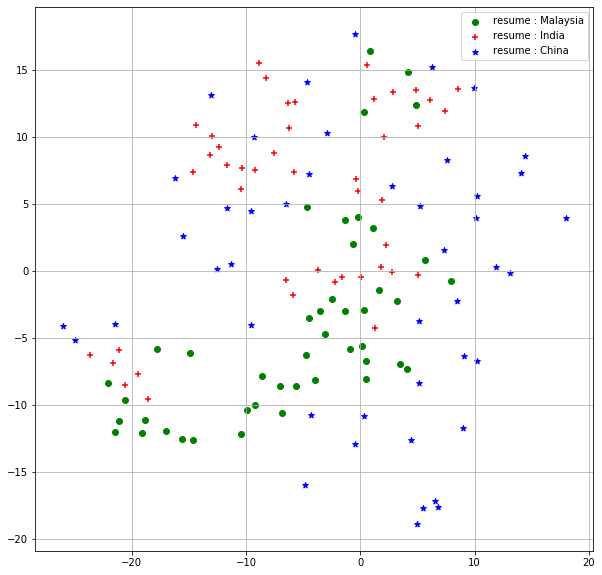

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_malaysia1.docx
                                     res_name  \
39               Muhibbah_Abdul Rahman_FM.doc   
131           HP_Adrian Hew_Acc Team Lead.pdf   
17             Maples_Kasturi Majumdar_VP.pdf   
134              Six Capital_MANJUNATH_FM.doc   
7    iProperty_Chan Lai Lin_Sr Accountant.pdf   
22      Steppe Capital_Radhika Shetty_FM.docx   
116  Red Money_Faizah Hassan_Finance Head.pdf   
99     Tour East_Vanessa Chiam_Finance AM.pdf   
126            Oracle_Deepa Natarajan_FC.docx   
26          HMGC_Smriti Gurung_Accountant.pdf   

                                          res_contents  \
39                                                [...   
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber...   
17   KASTURI MAJUMDAR Tel: + 65 82842308 Email: kas...   
134                                MANJUNATH MURDES...   
7    CHAN LAI LIN 33F, Sentul Union Flat Jalan Unio...   
22   Radhika Shetty   Mobile: +6

<Figure size 432x288 with 0 Axes>

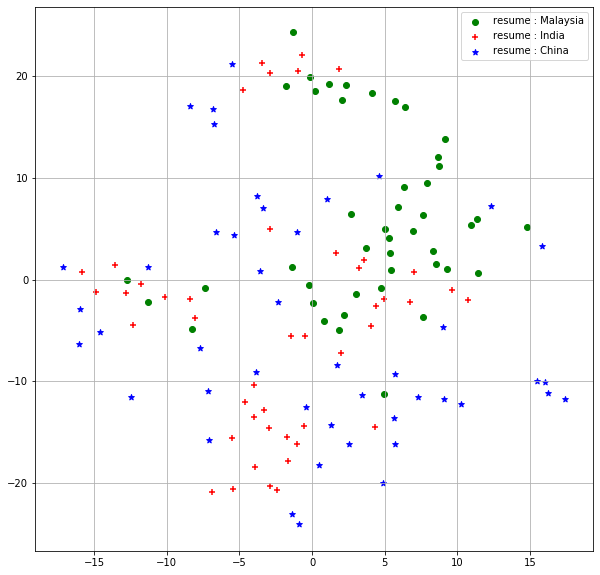

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india2.docx
                                              res_name  \
20          PE Firm_Arun Kumar_Investment Advisory.pdf   
130       Moody's_Huijuan Luo_Equity Reserarch AVP.pdf   
23       Stenvall Skld_Cai Xi_IB Senior Associate.pdf   
75                     S&P_Ellen Li_Credit Analyst.pdf   
8    Aglaia IM_Subhashini Gurumurthy_Sr Investment ...   
125                    EY_Helena He_Senior Auditor.pdf   
128      TriOptimal_LiuYangdan_Valuation Analytics.pdf   
94         Maybank AM_Varun Rao_Investment Analyst.doc   
10                        KPMG_Biao Fu_Deal Intern.pdf   
14   Probiz Capital_Fasiha Shaikh_BD Investment Dir...   

                                          res_contents                  name  \
20   ARUN KUMAR Dubai / New York|+971 529 776968, +...            Arun Kumar   
130  Huijuan Luo Mobile: 13811834894 E-mail: 138118...           Huijuan Luo   
23   Curriculum Vitae - CAI Xi PERSONALIA Re

<Figure size 432x288 with 0 Axes>

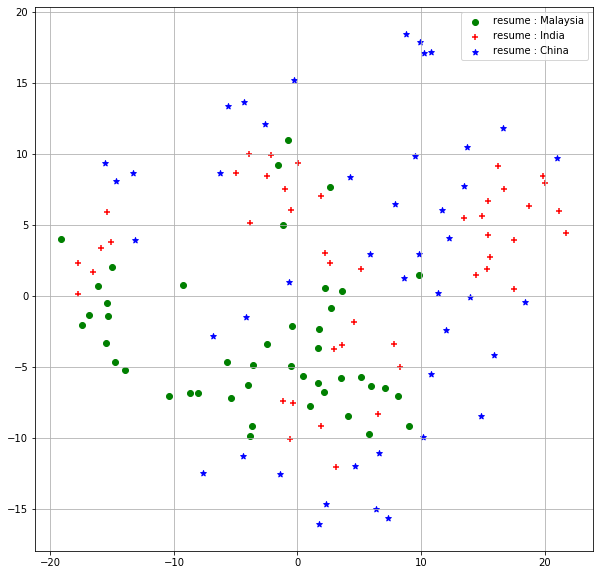

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india.docx
                                           res_name  \
56    Sunrise_Anusha Shashidhar_Pricing Finance.pdf   
131                 HP_Adrian Hew_Acc Team Lead.pdf   
134                    Six Capital_MANJUNATH_FM.doc   
17                   Maples_Kasturi Majumdar_VP.pdf   
79   Rasmala IB_Saba Tirpathur_Compliance Asst.docx   
86         Ocean Equity_Angus Gu_Equity Analyst.pdf   
81                  SMBC_Kerry Chin_Regional IA.pdf   
116        Red Money_Faizah Hassan_Finance Head.pdf   
23    Stenvall Skld_Cai Xi_IB Senior Associate.pdf   
12        Raffles Group_Garima Gupta_Cosec Exec.doc   

                                          res_contents  \
56   Resume Internal Audit Professional fa  Anusha ...   
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber...   
134                                MANJUNATH MURDES...   
17   KASTURI MAJUMDAR Tel: + 65 82842308 Email: kas...   
79   Saba Ambareen  Tirpathu

<Figure size 432x288 with 0 Axes>

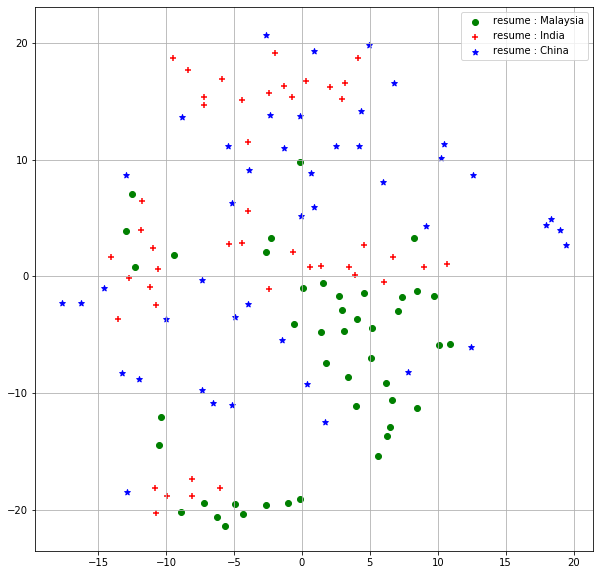

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_china1.docx
                                              res_name  \
92   Sunrise Brokers_Tim Huang_Equity Research Anal...   
27            Maxpro_Andrew Lee_Investment Manager.pdf   
93               Sequoia_Maggie Ma_Fund Accountant.pdf   
132     JPM_Yashen Zhang_Equity Research Associate.pdf   
90                       Equiom_Isaac Yim_Cosec AM.pdf   
111          Wintop_Michael Cao_Investment Manager.pdf   
134                       Six Capital_MANJUNATH_FM.doc   
100                            TB_Christine Liu_AD.pdf   
42      Morgan Stanley_Frankie Zhu_Equity Research.pdf   
59           JK Capital_Jackie Xu_Research Analyst.pdf   

                                          res_contents                  name  \
92   Tim Huang      +852 5646 1872      Thuang72@gm...             Tim huang   
27   Yaju (Andrew) Lee +852-9600-9822   b91704040@g...    Yaju (Andrew) Lee    
93   PERSONAL INFORMATION WORKING EXPERINECE

<Figure size 432x288 with 0 Axes>

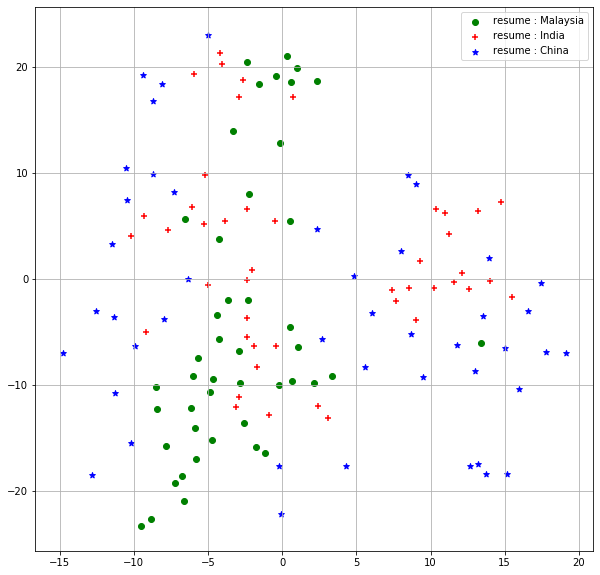

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india1.docx
                                            res_name  \
56     Sunrise_Anusha Shashidhar_Pricing Finance.pdf   
123  Zhenghe Capital_Rainbow Chen_Office Manager.pdf   
108          Godrej_Dhiraj Somani_Senior Manager.pdf   
131                  HP_Adrian Hew_Acc Team Lead.pdf   
52                SS&C_Amreeta Gujraty_AVP_Hedge.pdf   
91             Mohn_Nisha Babusathiam_Cosec Lead.doc   
121                 JTB_Chung Yon Jie_Accountant.pdf   
94       Maybank AM_Varun Rao_Investment Analyst.doc   
90                     Equiom_Isaac Yim_Cosec AM.pdf   
39                      Muhibbah_Abdul Rahman_FM.doc   

                                          res_contents  \
56   Resume Internal Audit Professional fa  Anusha ...   
123  Rainbow Chen  Email address: ml15@163.com Cont...   
108  Dhiraj Somani  Cell: +65 9126 9996, +91 90043 ...   
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber...   
52   Amreeta Guj

<Figure size 432x288 with 0 Axes>

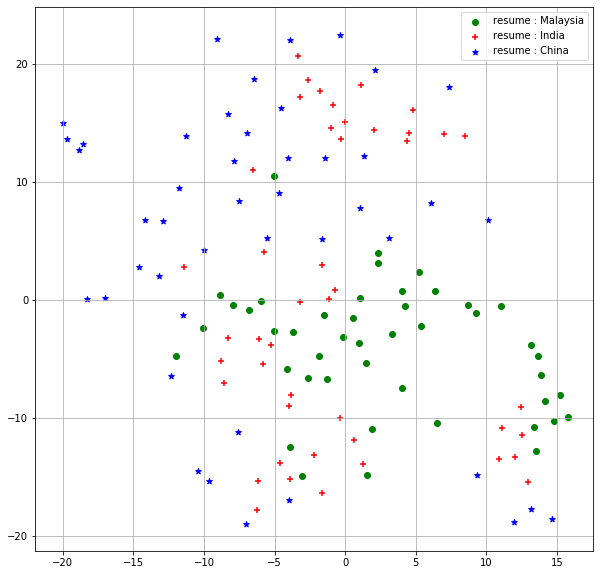

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_china.docx
                                         res_name  \
124                        RDM_Trevor Yang_FM.pdf   
28       Guotai_Esabella Zhao_Equity Research.pdf   
130  Moody's_Huijuan Luo_Equity Reserarch AVP.pdf   
86       Ocean Equity_Angus Gu_Equity Analyst.pdf   
72   Goldman Sachs_Feng Luo_Senior+Associate.docx   
71    Total Care_Yvette Jiang_Accounts Intern.pdf   
3               STI_Liz Wu_Investment Analyst.pdf   
4           Morningstar_Wenyin Xu_Insti Sales.pdf   
131               HP_Adrian Hew_Acc Team Lead.pdf   
125               EY_Helena He_Senior Auditor.pdf   

                                          res_contents  \
124  Trevor Siran YANG, CFA, CPA Tel: +852 67419184...   
28   Shuman Zhao (Esabella) +86 13632576879 | esabe...   
130  Huijuan Luo Mobile: 13811834894 E-mail: 138118...   
86   Angus Gu Mobile: (852) 5222 5490, (86) 147 149...   
72   Feng Luo  136 Joo Chiat Terrace, Singapore 42

<Figure size 432x288 with 0 Axes>

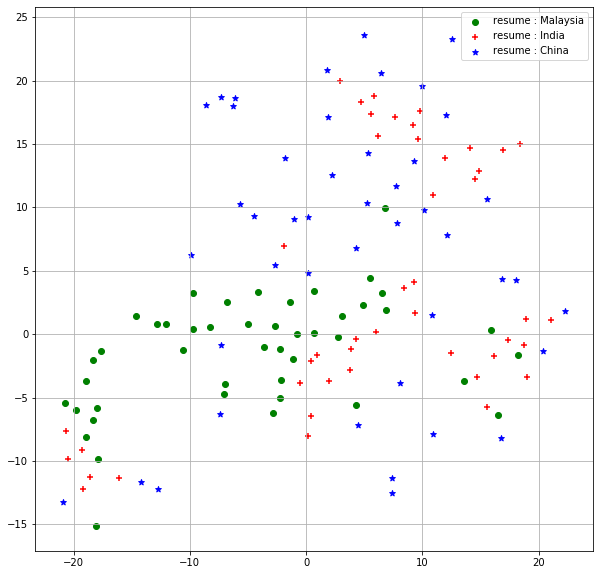

{'malaysia': defaultdict(<class 'int'>, {'total': 2, 'China': 2, 'India': 8, 'Malaysia': 10}), 'india': defaultdict(<class 'int'>, {'total': 3, 'India': 14, 'China': 10, 'Malaysia': 6}), 'china': defaultdict(<class 'int'>, {'total': 2, 'China': 18, 'India': 1, 'Malaysia': 1})}
{'malaysia': {'India': 4.0, 'Malaysia': 5.0, 'China': 1.0}, 'india': {'India': 4.666666666666667, 'Malaysia': 2.0, 'China': 3.3333333333333335}, 'china': {'India': 0.5, 'Malaysia': 0.5, 'China': 9.0}}


<Figure size 432x288 with 0 Axes>

In [16]:
if __name__ == '__main__':
    
    for file in os.listdir(jd_path):
        if file == '.DS_Store':
            continue
            
        filename = jd_path + file
        print(filename)
        processData(resume_path, filename, file)
    print(distributionMatrix)
    
    countryList = ['India', 'Malaysia', 'China']
    
    avgDistributionMatrix = {}
    for row in distributionMatrix.keys():
        avgDistributionMatrix[row] = {}
        totalJDCount = distributionMatrix[row]['total']
        for country in countryList:
            avgDistributionMatrix[row][country] = distributionMatrix[row][country] / totalJDCount
         
    print(avgDistributionMatrix)

In [18]:
concatDf.to_csv('/Users/Ketki/Documents/MS Theses/Reference Papers and Data/sampleP.csv')

In [30]:
cmin = concatDf['China'].min(axis=0)

In [32]:
imin = concatDf['India'].min(axis=0)
mmin = concatDf['Malaysia'].min(axis=0)

In [33]:
concatDf['China'] = concatDf['China'].fillna(cmin)
concatDf['India'] = concatDf['India'].fillna(imin)
concatDf['Malaysia'] = concatDf['Malaysia'].fillna(mmin)

In [34]:
concatDf

,China,India,Malaysia
aafm,0.022222,0.022222,0.022222
aaron,0.022222,0.022222,0.022222
abac,0.022222,0.022222,0.022222
abdul,0.022222,0.022222,0.311111
abilities,0.022222,0.111111,0.266667
...,...,...,...
zuellig,0.022222,0.022222,0.022222
zuhal,0.022222,0.022222,0.022222
zulkeeflee,0.022222,0.022222,0.022222
zumba,0.022222,0.022222,0.022222


In [36]:
r = (concatDf.min(axis=1)/concatDf.max(axis=1))
r

aafm          1.000000
aaron         1.000000
abac          1.000000
abdul         0.071429
abilities     0.083333
                ...   
zuellig       1.000000
zuhal         1.000000
zulkeeflee    1.000000
zumba         1.000000
zurich        0.500000
Length: 7430, dtype: float64

In [15]:
DF = concatDf.fillna(0.001)

In [16]:
r = (DF.min(axis=1)/DF.max(axis=1))
r

aafm          0.045000
aaron         1.000000
abac          0.045000
abdul         0.003214
abilities     0.003750
                ...   
zuellig       0.045000
zuhal         0.045000
zulkeeflee    0.045000
zumba         1.000000
zurich        0.022500
Length: 7430, dtype: float64

In [18]:
ratioP = pd.DataFrame(r)
ratioP

,0
aafm,0.045000
aaron,1.000000
abac,0.045000
abdul,0.003214
abilities,0.003750
...,...
zuellig,0.045000
zuhal,0.045000
zulkeeflee,0.045000
zumba,1.000000


In [20]:
ratioP = ratioP.reset_index()
ratioP

,index,0
0,aafm,0.045000
1,aaron,1.000000
2,abac,0.045000
3,abdul,0.003214
4,abilities,0.003750
...,...,...
7425,zuellig,0.045000
7426,zuhal,0.045000
7427,zulkeeflee,0.045000
7428,zumba,1.000000


In [21]:
ratioP = ratioP.rename(columns={'index':'words',0:'pRatio'})
ratioP

,words,pRatio
0,aafm,0.045000
1,aaron,1.000000
2,abac,0.045000
3,abdul,0.003214
4,abilities,0.003750
...,...,...
7425,zuellig,0.045000
7426,zuhal,0.045000
7427,zulkeeflee,0.045000
7428,zumba,1.000000
